In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join
from astropy.wcs import WCS

In [2]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 5

In [3]:
# Reduced data in txt files
merged_dat_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/"

In [4]:
# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(merged_dat_path+"merged_standards/m*.txt")
merged_standard_files

['A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mAnon1_M05.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHaro6-13_20190123_K_0083_spec_A0v.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHBC427_K6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHubble4_K8.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mJH108_M15.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa14_K5.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa1_M4.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa4_M2.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV410-Xray5a_M6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV830Tau_K75.txt']

In [5]:
# List of Class 3 Standards from MasterObservationList
# Spectral Types range from K1 to M6
# Will try to put to use later
standards_list = ["Anon1",
"DKTau",
"Haro 6-13",
"HBC 359",
"HBC 427",
"HD 286178",
"HQ Tau",
"Hubble 4",
"JH108",
"JH433",
"LkCa4",
"LkCa14",
"MHO 7",
"MHO 8",
"V410_xray5a",
"V830_tau",
"XEST09-042"
]
# standards_list = standards_list.sort()

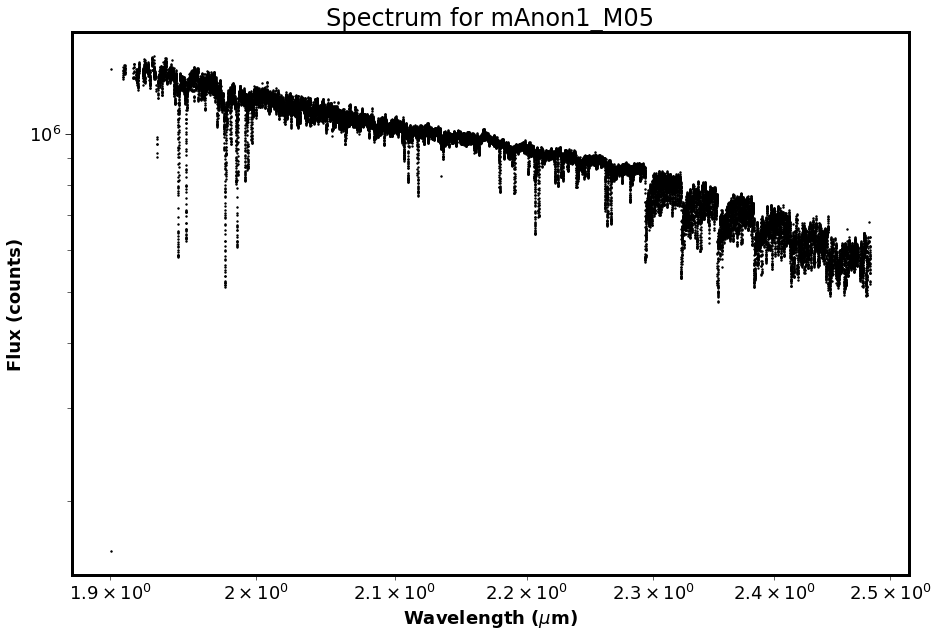

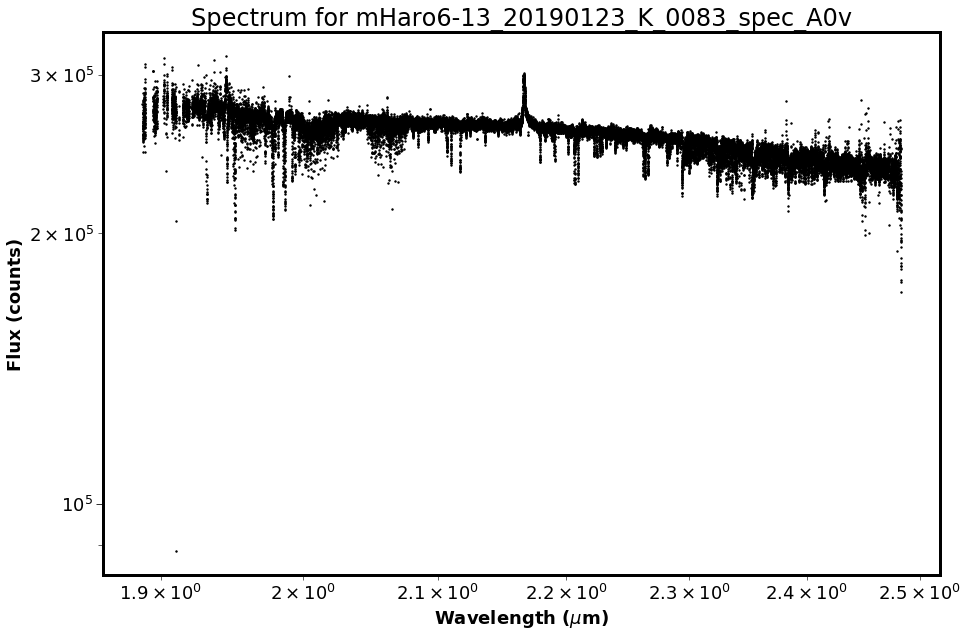

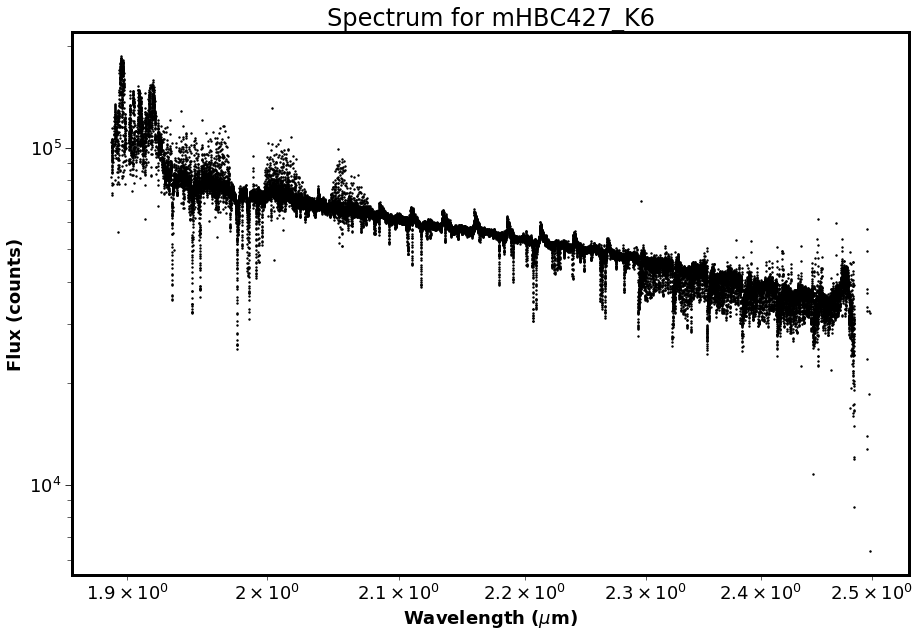

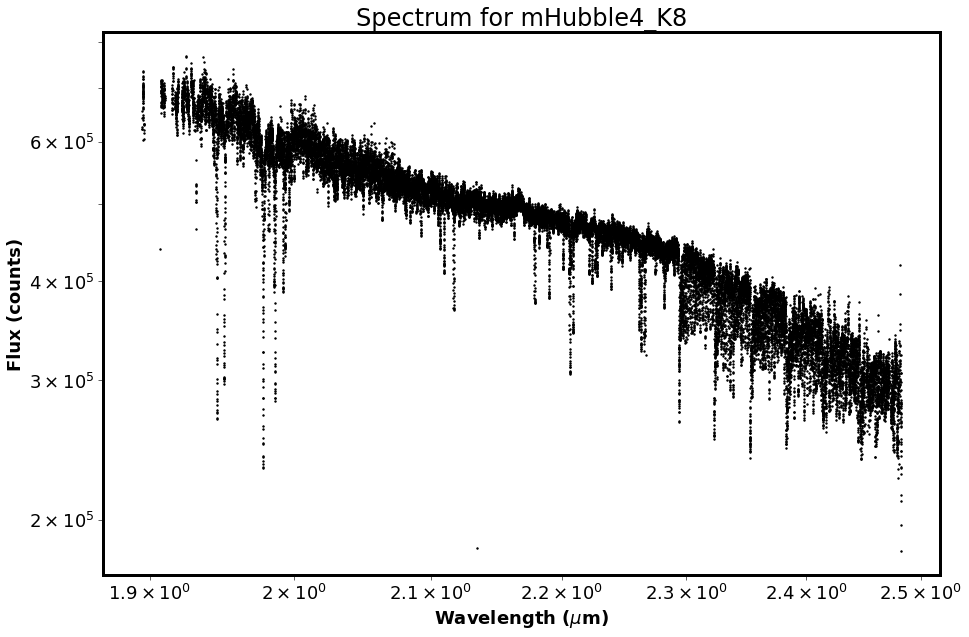

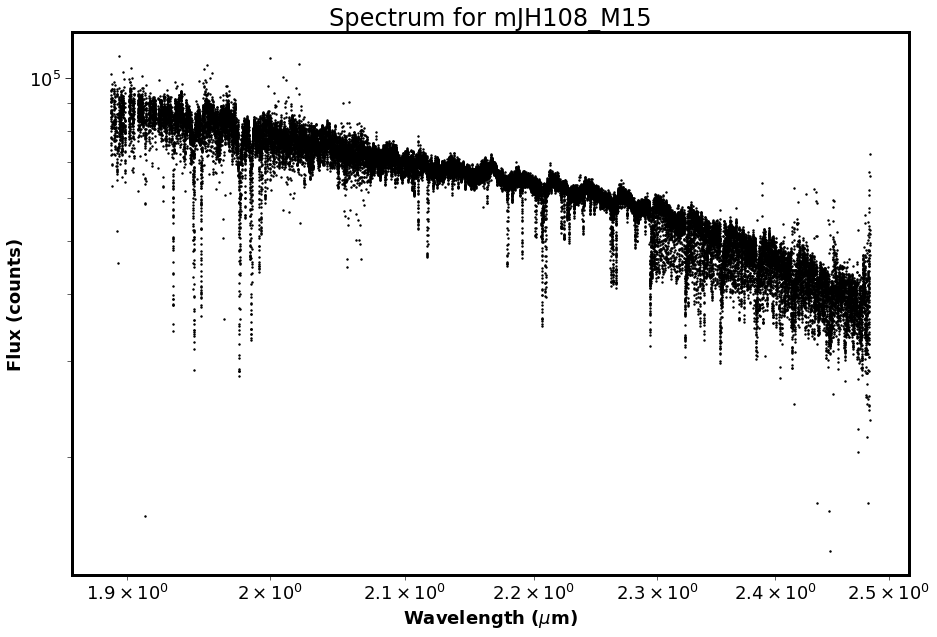

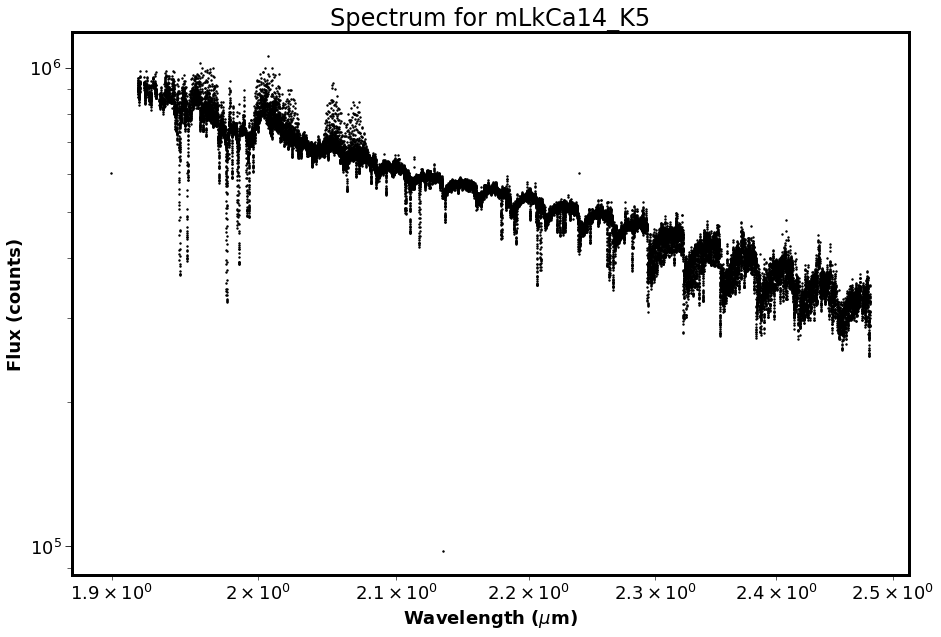

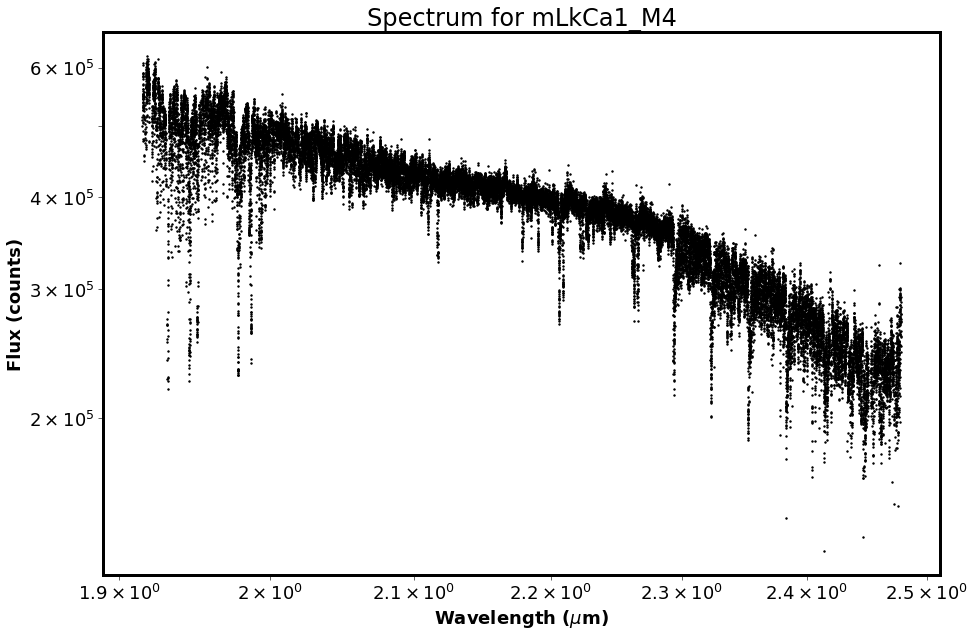

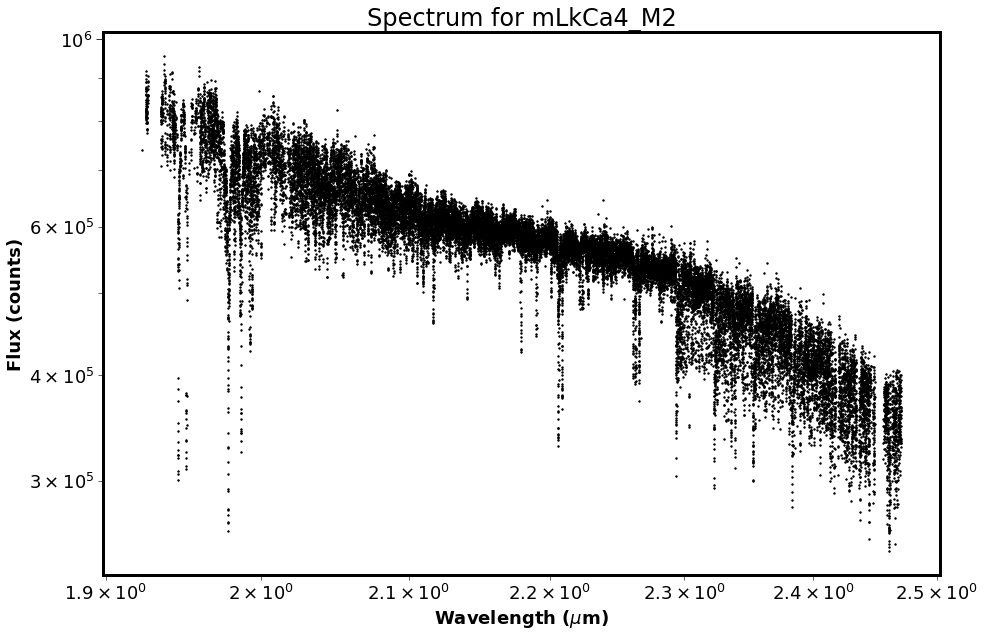

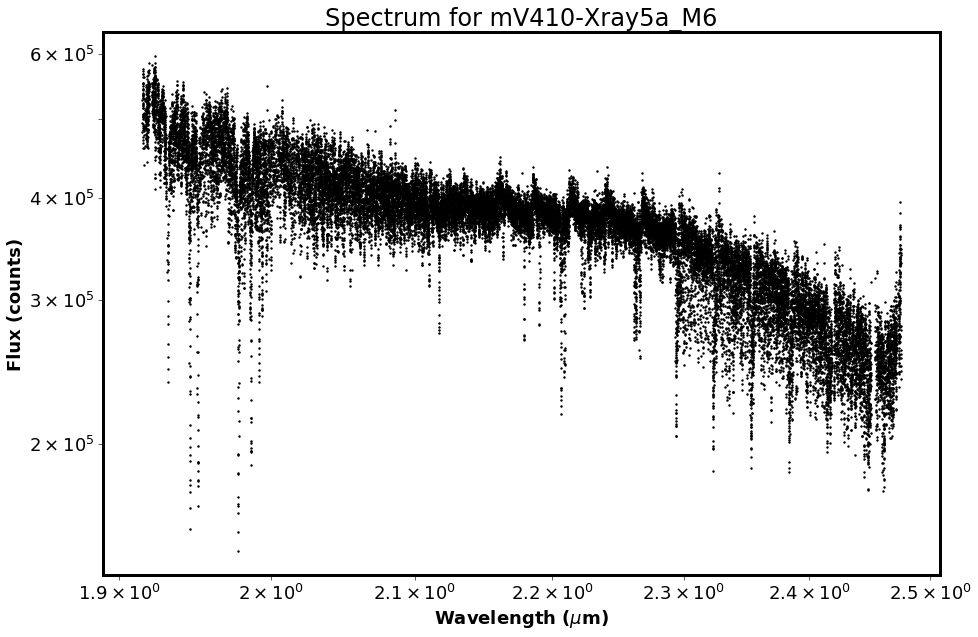

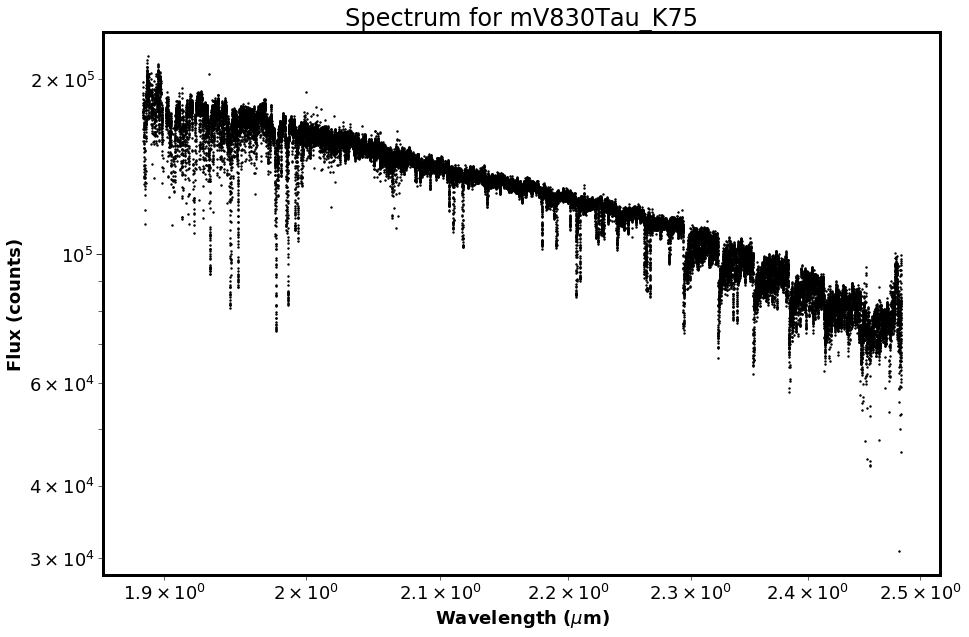

In [6]:
# Iterate over the TXT files
for file in merged_standard_files:
    # Read the data from the TXT file using pandas
    df = pd.read_csv(file, delimiter='\s+', comment='#', header=None)  # Adjust delimiter if necessary
    # For some weird reason column 3 has dtype 'object' so I change it to 'float64'
    df[2] = df[2].astype(float)
    # Exclude any negative flux, anything with  10000 < SNR < 5 only because I don't actually know what the 3rd column is
    df = df[(df[1] > 0) & (df[2] >= 5) & (df[2] <= 10000)]
    # Extract wavelength and flux columns
    wavelength = df[0]
    flux = df[1]

    # Create a plot of wavelength vs. flux
    fig,ax = plt.subplots(figsize=(15,10))

    ax.scatter(wavelength, flux,s=2,c='black')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.set_ylabel('Flux (counts)')

    # Extract the filename from the path
    filename = os.path.splitext(os.path.basename(file))[0]
    # Make the title according to the filename
    ax.set_title('Spectrum for {}'.format(filename))
    
    # Save the plot as PNG
    plt.savefig(fig_path+'{}.png'.format(filename))
    # Show the plot
    # plt.show()